## To analyse the brain segmentation results

In [1]:
RUN_ID = 0
MASK_CODE = 1
# USE_PROCESSED = True
# ONLY_MEDIAN = False
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/brats_seg"
DATA_ROOT_DIR = "/scratch1/sachinsa/data"

In [2]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.logger import Logger
from utils.plot import *
from itertools import chain, combinations

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir = os.path.join("..", "figs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [4]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']
    metric_values_tc = training_info['metric_values_tc']
    metric_values_wt = training_info['metric_values_wt']
    metric_values_et = training_info['metric_values_et']

In [5]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)
logger.info(f"Total epochs: {max_epochs}")

[INFO] Total epochs: 2


In [6]:
def all_subsets(arr):
    subsets = list(chain.from_iterable(combinations(arr, r) for r in range(0, len(arr))))
    return [list(subset) for subset in subsets]

mask_indices = all_subsets([0, 1, 2, 3])[MASK_CODE]
show_indices = [x for x in [0, 1, 2, 3] if x not in mask_indices]
channels = ["FLAIR", "T1w", "T1Gd", "T2w"]
label_list = ["TC", "WT", "ET"]

logger.info(f"Masked contrasts: {[channels[i] for i in mask_indices]}")

[INFO] Masked contrasts: ['FLAIR']


### Plot the loss and metric

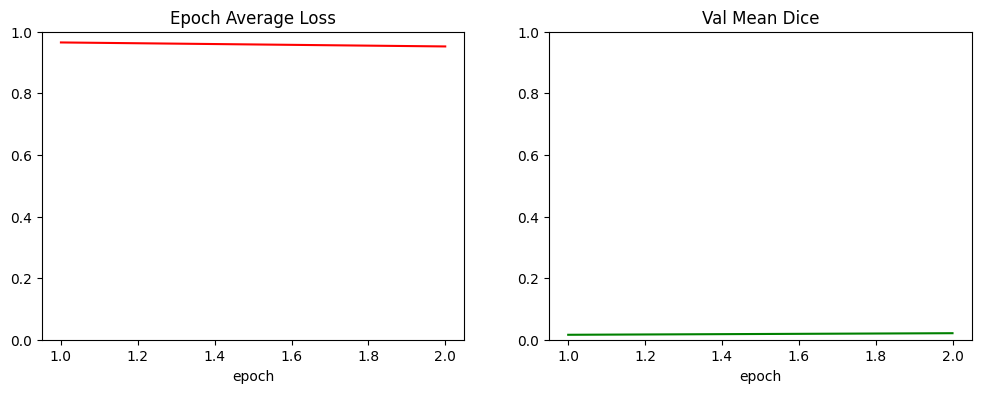

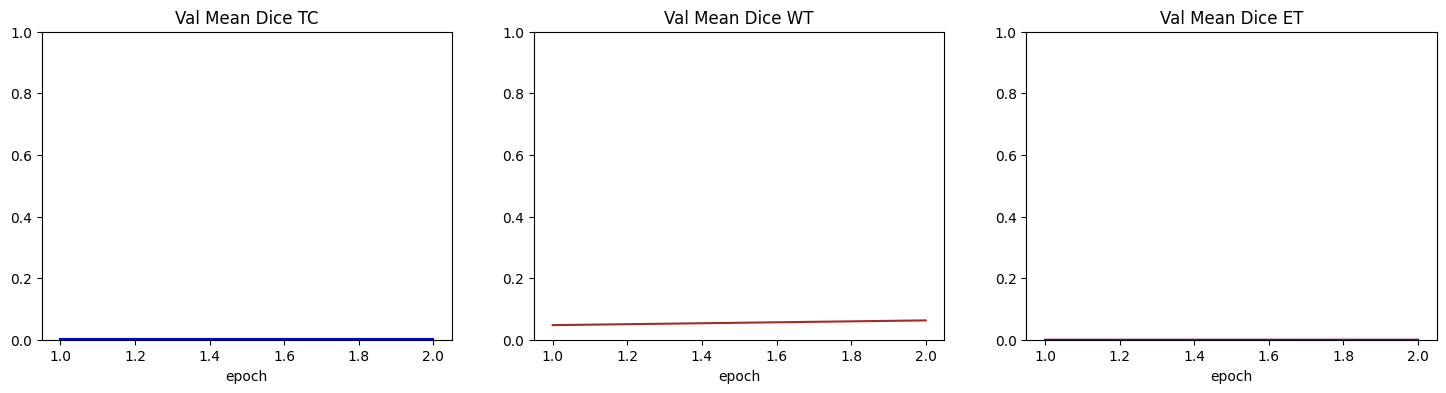

In [7]:
plt.figure("train", (12, 4))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 4))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="purple")
plt.show()

metric: 0.021
metric_tc: 0.001
metric_wt: 0.063
metric_et: 0.000


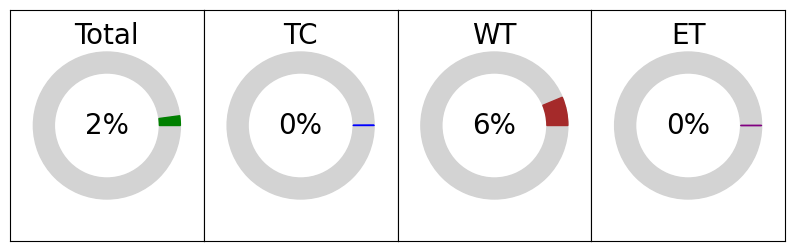

In [8]:
metric = np.max(metric_values)
arg_max = np.argmax(metric_values)
metric_tc = metric_values_tc[arg_max]
metric_wt = metric_values_wt[arg_max]
metric_et = metric_values_et[arg_max]

print(f"metric: {metric:.3f}")
print(f"metric_tc: {metric_tc:.3f}")
print(f"metric_wt: {metric_wt:.3f}")
print(f"metric_et: {metric_et:.3f}")


fig, axs = plt.subplots(1,4, figsize=(10, 3),gridspec_kw={'wspace': 0, 'hspace': 0})
plot_donut(metric, "Total", "green", axs[0])
plot_donut(metric_tc, "TC", "blue", axs[1])
plot_donut(metric_wt, "WT", "brown", axs[2])
plot_donut(metric_et, "ET", "purple", axs[3])
plt.show()

## Inference on the model

In [9]:
import torch
from monai.transforms import (
    Compose,
)
from monai.config import print_config
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
)
from monai.utils import set_determinism

from tqdm import tqdm
from utils.transforms import tumor_seg_transform as data_transform
from utils.model import create_SegResNet, inference
from utils.dataset import BraTSDataset

In [10]:
device = torch.device("cuda:0")
in_channels = len(show_indices)
model = create_SegResNet(in_channels, device)

In [11]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [12]:
val_dataset = BraTSDataset(
    version='2017',
    # processed = USE_PROCESSED,
    section = 'validation',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)

In [13]:
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [15]:
with torch.no_grad():
    this_input = val_dataset.get_with_id(328)
    input_image = this_input["image"].unsqueeze(0).to(device)
    input_image = input_image[:, show_indices, ...]
    input_label = this_input["label"]
    this_output = inference(input_image, model)
    this_output = post_trans(this_output[0])

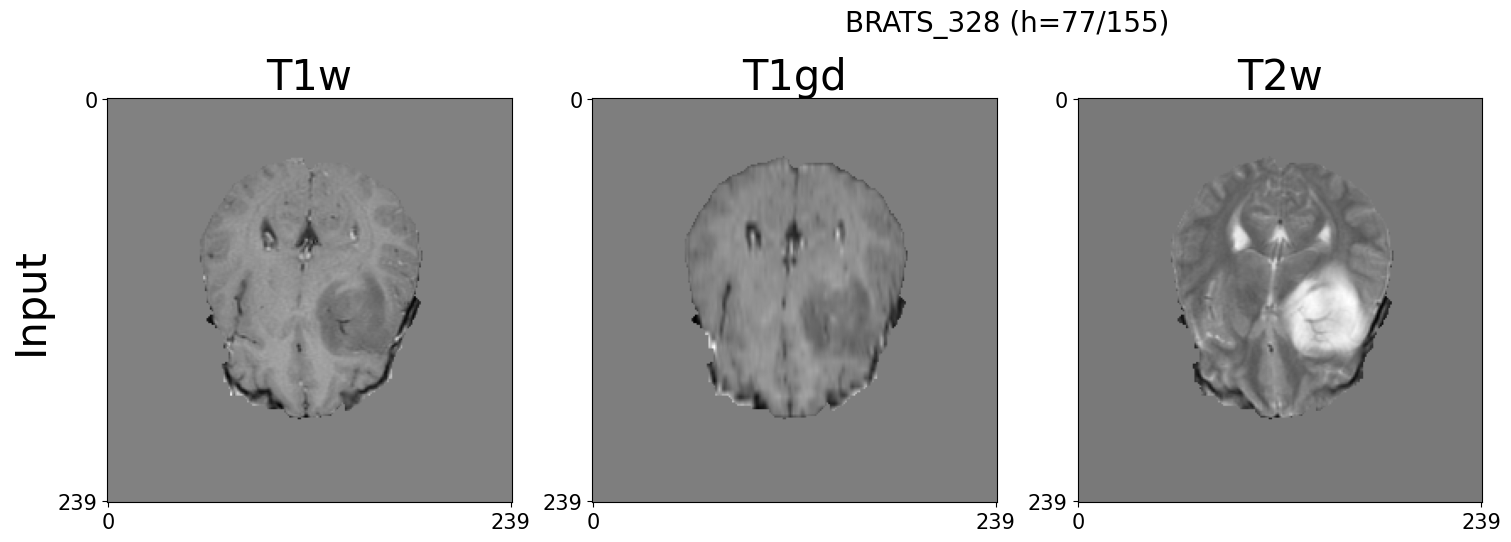

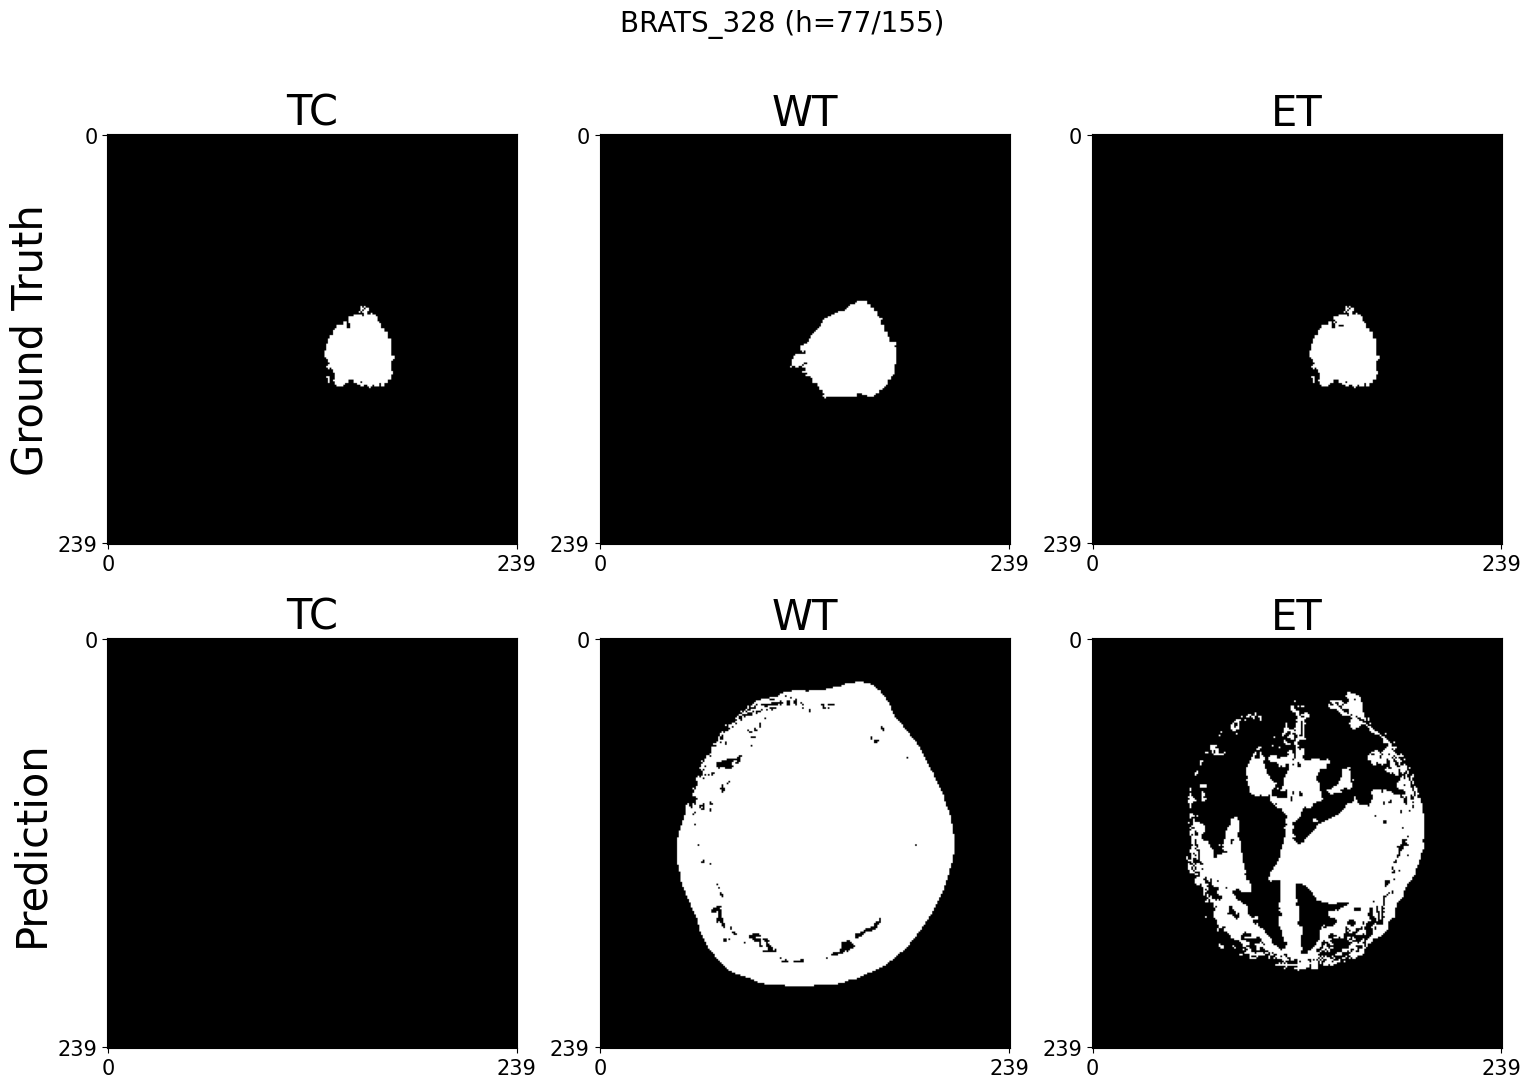

In [19]:
_, _, im_length, im_width, im_height = input_image.shape
h_index = im_height//2
label_list = ["TC", "WT", "ET"]
channels = ["FLAIR", "T1w", "T1gd", "T2w"]

def plot_brain(index, label):
    if label == "ground_truth":
        start_index = 0
        brain_slice = input_label
        title = "Ground Truth"
    elif label == "prediction":
        start_index = len(label_list)
        brain_slice = this_output
        title = "Prediction"

    brain_slice = brain_slice[index, :, :, 70].detach().cpu().T
    plt.subplot(2, 3, start_index + index + 1)
    plt.title(label_list[index], fontsize=30)
    if index == 0:
        plt.ylabel(title, fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    plt.imshow(brain_slice, cmap="gray")


plt.figure("image", (24, 6))
for i in range(len(show_indices)):
    plt.subplot(1, 4, i + 1)
    plt.title(channels[show_indices[i]], fontsize=30)
    if i == 0:
        plt.ylabel("Input", fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    plt.imshow(input_image[0, i, :, :, 70].detach().cpu().T, cmap="gray")
plt.suptitle(f"BRATS_{this_input['id']} (h={h_index}/{im_height})", fontsize=20)
plt.show()
    
plt.figure("label", (18, 12))
for i in range(len(label_list)):
    plot_brain(i, "ground_truth")
for i in range(len(label_list)):
    plot_brain(i, "prediction")
plt.suptitle(f"BRATS_{this_input['id']} (h={h_index}/{im_height})", fontsize=20)
plt.show()